### Necessary Packages

In [1]:
import sys
import os
import seaborn as sns
import pandas as pd
sys.path.append('../..')
import torch
import definitions as D
import matplotlib.pyplot as plt
import imageio
from src.models import LatentDiffusion
from src.utils import get_last_checkpoint,load_json
from src.training.diffusion import Config
from src.utils import make_grid,seed_everything
from IPython import display

In [2]:
sns.set_theme(style="darkgrid",palette='husl')

### Reproducibility

In [3]:
SEED = 42
seed_everything(SEED)

### Load configurations

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EXPIREMENT = 'diffsuion_cartoon_cond'
CONFIG_PATH = os.path.join(D.EXPERIMENTS_DIR,EXPIREMENT,'config.json')

In [5]:
config = Config(**load_json(CONFIG_PATH))

### Load models

In [6]:
CHECKPOINT_PATH = os.path.join(D.EXPERIMENTS_DIR,EXPIREMENT,'checkpoints')
CHECKPOINT = get_last_checkpoint(CHECKPOINT_PATH)
model = LatentDiffusion(config.model_config).to(DEVICE).eval()
model.load_state_dict(CHECKPOINT)

<All keys matched successfully>

### History

In [7]:
history_path = os.path.join(D.EXPERIMENTS_DIR, EXPIREMENT, 'history.csv')
history = pd.read_csv(history_path)

<Axes: xlabel='epoch', ylabel='loss'>

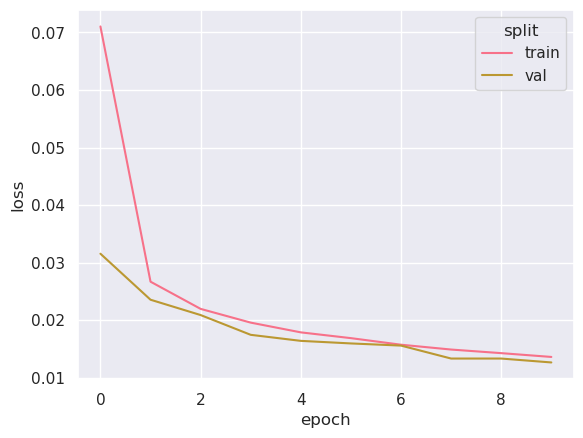

In [8]:
sns.lineplot(data=history, x='epoch', y='loss', hue='split')

### Generate fake images

- Unconditionally

In [9]:
noise = torch.randn(16, 3, 16, 16).to(DEVICE)
_,images = model.generate(noise, decode_every=20,progress=True,device='cpu')

  0%|          | 0/1000 [00:00<?, ?it/s]

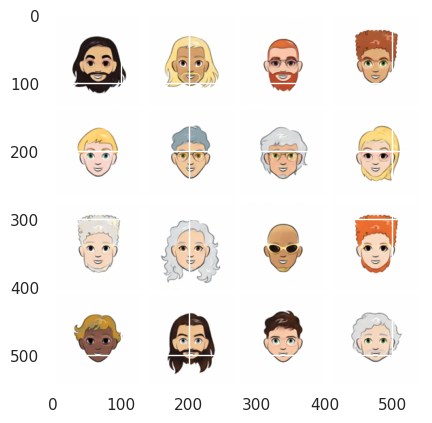

In [10]:
grid = make_grid(images[-1],4,4,4,1.0)
plt.imshow(grid)

- With condition (without classifier free guidance)

In [11]:
metadata = {
    "hair_color" : torch.ones(16,).long().to(DEVICE) * 1,
    "face_shape" : torch.ones(16,).long().to(DEVICE) * 0,
}

In [12]:
noise = torch.randn(16, 3, 16, 16).to(DEVICE)
_,images = model.generate(noise, metadata, decode_every=20,progress=True,device='cpu')

  0%|          | 0/1000 [00:00<?, ?it/s]

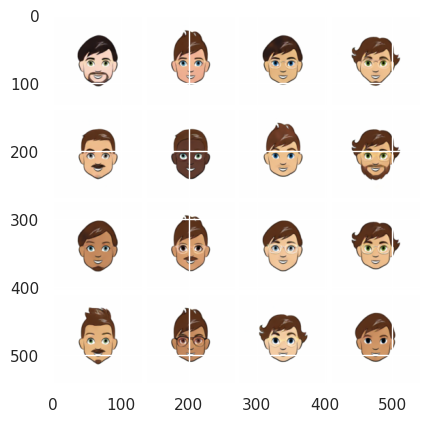

In [13]:
grid = make_grid(images[-1],4,4,4,1.0)
plt.imshow(grid)

- With condition (with classifier free guidance)

In [14]:
_,images = model.generate(noise, metadata,cf_scale=1.25, decode_every=20,progress=True,device='cpu')

  0%|          | 0/1000 [00:00<?, ?it/s]

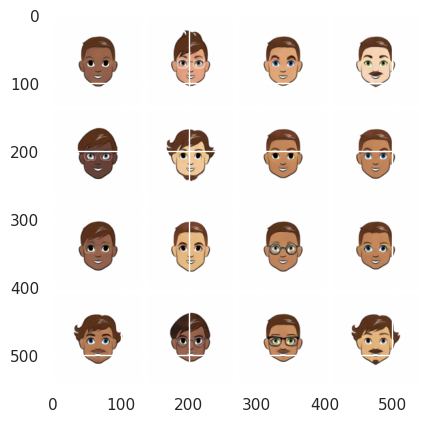

In [15]:
grid = make_grid(images[-1],4,4,4,1.0)
plt.imshow(grid)

### Visualize generation process

In [16]:
grid = make_grid(images,4,4,4,1.0)
grid = 255 * grid
grid = grid.type(torch.uint8)

In [17]:
frames = list(grid.numpy())

In [18]:
gif_path = os.path.join(D.EXPERIMENTS_DIR,EXPIREMENT,'generation_process.gif')

In [19]:
imageio.mimsave(gif_path,frames)

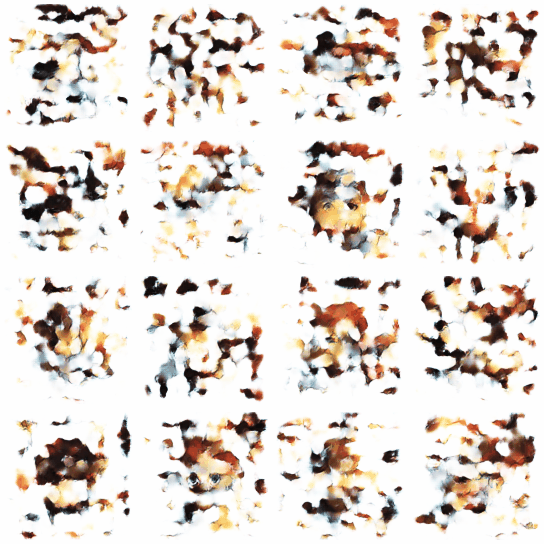

In [20]:
display.Image(filename=gif_path)